In [1]:
from diting import *

from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: No module named 'diting'

In [2]:
work_dir = "tutorial/"
target_feature = "type"

encoding = [kmerEncoding2D]
params = [[1, 1]]
feature_names = ["diting_seq_kmer_1_1"]

In [3]:
data_file_1 = work_dir + "data/CTCF.fasta"
data_file_2 = work_dir + "data/GATA3.fasta"

data_1 = parse_fasta(data_file_1, "CTCF", 600, 24)
data_2 = parse_fasta(data_file_2, "GATA3", 600, 24)
data = pd.concat([data_1, data_2], ignore_index=True)
data = data[["diting_seq", target_feature]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
diting_seq    3000 non-null object
type          3000 non-null object
dtypes: object(2)
memory usage: 47.0+ KB


[Text(0, 0.5, 'Binding Sites (total: 3000)'),
 [],
 Text(0.5, 0, 'TF (total: 2)')]

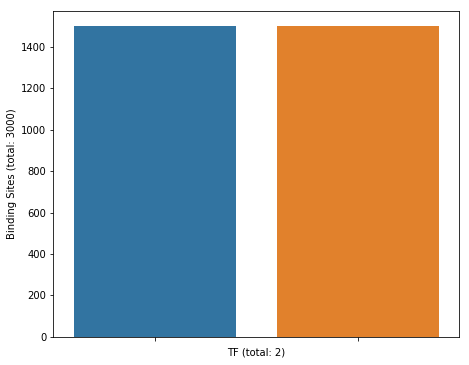

In [4]:
data.info()
#data.head()
data[target_feature].value_counts()

fig1 = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax1 = sns.countplot(data[target_feature],order=data[target_feature].value_counts().index)
ax1.set(xlabel="TF (total: 2)", xticklabels="",
       ylabel="Binding Sites (total: 3000)")

In [5]:
train, val, test = separateData(data, target_feature, 500, [0.4,0.5])
train.to_pickle(work_dir + "train.pkl")
val.to_pickle(work_dir + "val.pkl")
test.to_pickle(work_dir + "test.pkl")

In [7]:
saveKmerEncodedMat(work_dir, feature_names, target_feature, train, "train", encoding, params)
saveKmerEncodedMat(work_dir, feature_names, target_feature, val, "val", encoding, params)
saveKmerEncodedMat(work_dir, feature_names, target_feature, test, "test", encoding, params)

In [4]:
models = [model_CNN]
ensembledModels = []
preds_val = []
preds_test = []
for feat in feature_names:
    X_train, y_train, inputShape, numClasses = loadKmerEncodedMat(work_dir, feat, target_feature, "train", "3D")
    X_val, y_val, inputShape, numClasses = loadKmerEncodedMat(work_dir, feat, target_feature, "val", "3D")
    X_test, y_test, inputShape, numClasses = loadKmerEncodedMat(work_dir, feat, target_feature, "test", "3D")
    for mod in models:
        tmpModel = mod(work_dir, feat, target_feature)
        ensembledModels.append(tmpModel)
        preds_val.append(tmpModel.predict(X_val))
        preds_test.append(tmpModel.predict(X_test))


|   iter    |  target   | n_batc... |  n_epoch  | n_filters | n_kern... |  n_units  |
-------------------------------------------------------------------------------------
|  1        |  0.5167   |  7.958    |  12.26    |  13.2     |  3.398    |  15.3     |
|  2        |  0.8278   |  3.816    |  37.18    |  8.131    |  14.88    |  6.394    |
|  3        |  0.79     |  10.53    |  50.55    |  14.15    |  14.26    |  2.447    |
|  4        |  0.7578   |  15.29    |  93.51    |  3.098    |  10.48    |  1.657    |
|  5        |  0.8511   |  5.215    |  88.64    |  15.4     |  9.902    |  13.88    |
|  6        |  0.4844   |  1.0      |  67.09    |  1.0      |  16.0     |  24.0     |
|  7        |  0.5      |  1.0      |  1.0      |  1.0      |  16.0     |  1.0      |
{'params': {'n_epoch': 88.6427184315835, 'n_batch_size': 5.215048249190819, 'n_kernel_size': 9.901664024694593, 'n_units': 13.880997322926056, 'n_filters': 15.39977575355852}, 'target': 0.851111119074954}
_____________________

In [5]:
X_val, y_val, inputShape, numClasses = loadKmerEncodedMat(work_dir, feature_names[0], target_feature, "val", "3D")
error, best = getBestEnsemble(len(ensembledModels), 100, 1, preds_val, y_val)
error, best

(0.13666666666666666, array([1.]))

In [6]:
test_score = 1
total = 0.0
for i in range(len(ensembledModels)):
    total += best[i]*preds_test[i]
total = np.argmax(total, axis=1)
test_score = np.sum(np.not_equal(total, np.argmax(y_test, axis=1))) / y_test.shape[0]
test_score = 1 - test_score
test_score

0.8466666666666667

In [3]:
model = load_model(work_dir+feature_names[0]+"_cnn.h5")
layerName_filter = "conv2d_1"
layerName_dense_2 = "dense_2"

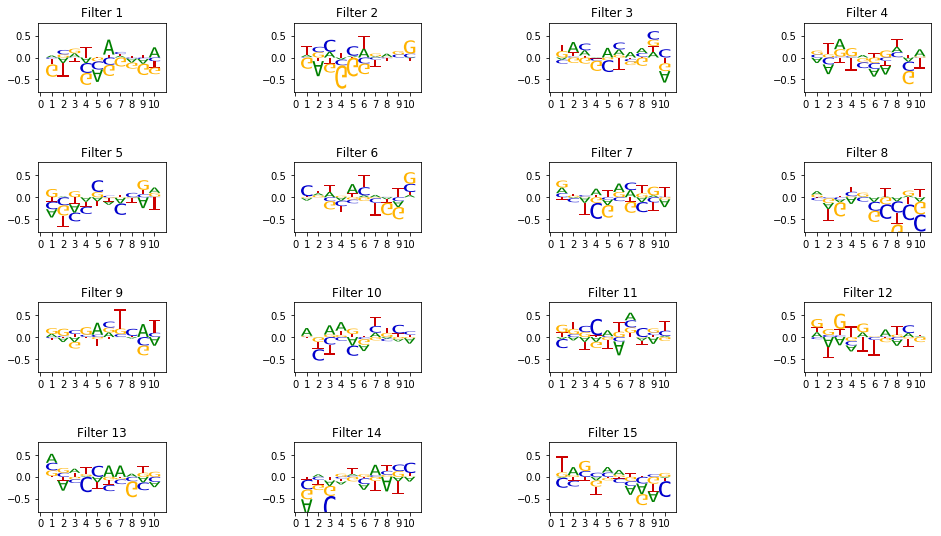

In [9]:
fig2 = plot_CNNfilters(model, layerName_filter, "text", [-0.8,0.8])
fig2.savefig(work_dir+"fig2.pdf")

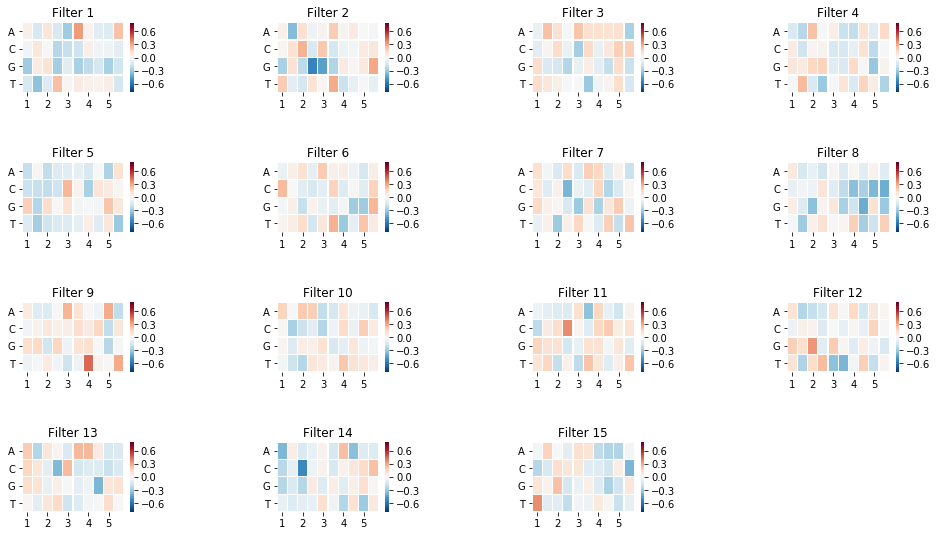

In [10]:
fig3 = plot_CNNfilters(model, layerName_filter, "heatmap", [-0.8,0.8])
fig3.savefig(work_dir+"fig3.pdf")

In [4]:
Seqs_train = pd.read_pickle(work_dir+"train.pkl")["diting_seq"]
X_train, y_train, inputShape, numClasses = loadKmerEncodedMat(work_dir, feature_names[0], target_feature, "train", "3D")

In [12]:
getSeqMotifs(model, layerName_filter, X_train, Seqs_train, work_dir)

In [5]:
candidate_mat = X_train[0:2]
candidate_seq = Seqs_train[0:2]
candidate_importance = getSeqImportance(model, layerName_dense_2, candidate_mat)

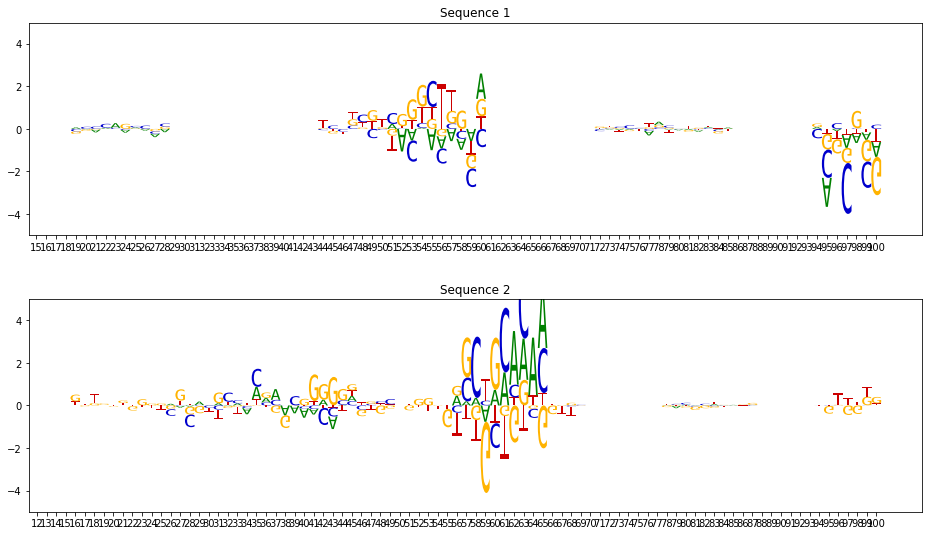

In [7]:
fig4 = plot_Sequences(candidate_importance, range(200,300), "text", [-5,5])
fig4.savefig(work_dir+"fig4.pdf")

In [6]:
scores = getMutationScores(candidate_seq, range(200,300), candidate_mat, model, encoding[0], params[0])

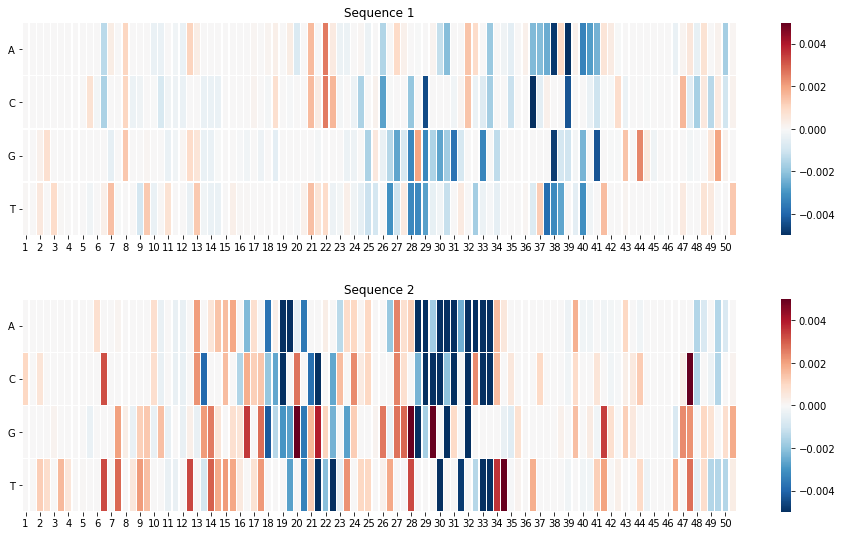

In [10]:
fig5 = plot_Mutations(scores, range(0,100), "heatmap", [-.005,.005])
fig5.savefig(work_dir+"fig5.pdf")